In [18]:
import os
import geopandas as gpd
from geopandas import GeoSeries
import pandas as pd
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt

lithoprobe = gpd.read_file("data/lithoprobe.geojson")
monitoring_areas = gpd.read_file("data/KSMMA.geojson")
faults_bfsz = gpd.read_file("data/Mei_2009_faults_BFSZ.shp")
faults_montney = gpd.read_file("data/Mei_2009_faults_Montney.shp")
faults_debolt = gpd.read_file("data/Mei_2009_faults_Debolt.shp")
wells = gpd.read_file("data/wells_close_to_lithoprobe.csv")


In [19]:
# lithoprobe = gpd.read_file(litpoprobe_file)
# faults = gpd.read_file(faults_file)
# monitoring_areas = gpd.read_file(monitoring_area_file)
# wells = pd.read_csv(wells_file)

Convert well dataframe to geodataframe

In [20]:
wells = wells.rename(columns = {"Bot-Hole Longitude (NAD27)":"X",
                                "Bot-Hole Latitude (NAD27)":"Y"})
wells['geometry'] = wells.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)
wells_gdf = gpd.GeoDataFrame(wells, geometry='geometry', crs=4326)

Change coordinates of the objects from WGS84 to UTM NAD83 to create the buffer in meters, not degrees

In [30]:

epsg = 32610
wells_utm = wells_gdf.to_crs(epsg=epsg)
monitoring_areas_utm = monitoring_areas.to_crs(crs=epsg)
lithoprobe_utm = lithoprobe.to_crs(crs=epsg)

Create the buffer along the lithoprobe

We have to be careful as the buffer operation updates the geometry column very time wee run the cell below 

In [31]:
buffer = 5000 
lithoprobe_utm['geometry'] = lithoprobe_utm.geometry.buffer(buffer)

Once we have our buffer, let's convert it back to WGS84

Number of wells 5.0 km from the lithoprobe line: 56


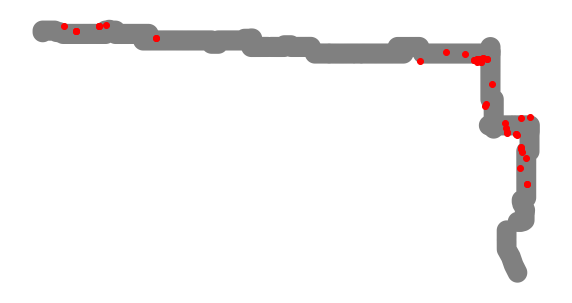

In [32]:
lithoprobe_buffer_wgs84 = lithoprobe_utm.to_crs(crs=4326)

well_subset_utm = gpd.overlay(wells_utm, lithoprobe_utm)
well_subset = well_subset_utm.to_crs(crs=4326)
print("Number of wells", buffer/1000, "km from the lithoprobe line:", well_subset.shape[0])

fig, ax = plt.subplots(figsize=(10, 10))
lithoprobe_buffer_wgs84.plot(ax=ax,color='grey')
well_subset.plot(ax=ax,color='red')
ax.set_axis_off()
ax.grid(True)
plt.show()

In [33]:
import base64
from IPython.display import IFrame

m = folium.Map([43,-100], zoom_start=4)

encoded = base64.b64encode(open('data/image.png','rb').read())
html = '''<img src="data:image/png;base64,{}">'''.format
iframe = IFrame(html(encoded.decode('UTF-8')), width=100, height=200)
popup = folium.Popup(iframe, max_width=100)

folium.Marker([52,-120], popup=popup).add_to(m)
m

In [90]:
from folium import plugins

import base64
from IPython.display import IFrame


big_map = folium.Map(location=[55.91, -119], zoom_start = 8, control_scale=True)# add plugin mini map
mini_map = plugins.MiniMap(toggle_display=True)# add the mini map to the big map
big_map.add_child(mini_map)

for row in well_subset.iterrows():
    
    location = ([row[1][0], row[1][1]])
    popup = ('\nlat:' + str(row[1][0]) + 
             '\nlon:' + str(row[1][1]))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(big_map) 
    
#     encoded = base64.b64encode(open('data/image.png', 'rb').read())
#     html1 = '''<img src="data:image/png;base64,{}">'''.format
#     iframe = IFrame(html(encoded.decode('UTF-8')), width=100, height=200)
#     popup = folium.Popup(iframe, max_width=400)
#     folium.Marker(location,tooltip=html1, popup=popup).add_to(big_map)
    

folium.GeoJson(lithoprobe).add_to(big_map)
folium.GeoJson(monitoring_areas,
    style_function=lambda x: {
        'color' : 'red',
        'weight' : 2,
        'opacity': 0.7,
        'fillColor' : 'blue',
        }).add_to(big_map)


big_map

In [99]:
well_subset[well_subset['line_num'] =='11']

,Y,X,Bot-Hole Easting (NAD27),Bot-Hole Northing (NAD27),Well Unique Identifier,line_num,begin,end,geometry
47,55.88047,-119.61148,336640.1,6195645,343,11,11,11,POINT (-119.61148 55.88047)
48,55.93988,-120.0087,686825.4,6203215.7,397,11,11,11,POINT (-120.00870 55.93988)
49,55.93238,-120.06513,683337.6,6202230.2,398,11,11,11,POINT (-120.06513 55.93238)
50,55.93238,-120.06513,683337.6,6202230.2,399,11,11,11,POINT (-120.06513 55.93238)
51,55.93238,-120.06513,683337.6,6202230.2,400,11,11,11,POINT (-120.06513 55.93238)
52,55.9119,-120.24115,672436.5,6199499.2,401,11,11,11,POINT (-120.24115 55.91190)
53,55.9119,-120.24115,672436.5,6199499.2,402,11,11,11,POINT (-120.24115 55.91190)
54,55.9119,-120.24115,672436.5,6199499.2,403,11,11,11,POINT (-120.24115 55.91190)
55,55.9325,-120.3381,666289.8,6201553.5,404,11,11,11,POINT (-120.33810 55.93250)


change coordinates to UTM Nad27 (epsg=26711)

In [46]:
lithoprobe_26711 = lithoprobe.to_crs(epsg=26711)
faults_bfsz_26711 = faults_bfsz.to_crs(epsg=26711)
faults_montney_26711 = faults_montney.to_crs(epsg=26711)
faults_debolt_26711 = faults_montney.to_crs(epsg=26711)

get intersection of the lithoprobe lines with the faults 

In [47]:
# https://gis.stackexchange.com/questions/252474/intersecting-lines-to-get-points-in-geopandas
points = lithoprobe_26711.unary_union.intersection(faults_debolt_26711.unary_union)
points_gs = GeoSeries(point for point in points)# from geopandas import GeoSeries

points_gdf = gpd.GeoDataFrame(gpd.GeoSeries(points_gs))
points_gdf = points_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
points_gdf.crs = {'init':'epsg:26711'}

/home/paulina/anaconda3/envs/geol_susc/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Plot it together and show easting coordinate of the intersected points

In [48]:
gravi_df = pd.read_csv("data/Canada_Gravity_2018.csv", sep=",")
gdf = gpd.GeoDataFrame(
    gravi_df, geometry=gpd.points_from_xy(gravi_df.X, gravi_df.Y), crs=4326)

gdf_utm = gdf.to_crs(crs=26711) #  to have distance in meters
lithoprobe_utm = lithoprobe.to_crs(26711)

buffer = 500
lithoprobe_utm['geometry'] = lithoprobe_utm.geometry.buffer(buffer)

points_subset = gpd.overlay(gdf_utm, lithoprobe_utm)
print("Gravity measurements along the lithoprobe:", points_subset.shape[0])

Gravity measurements along the lithoprobe: 752


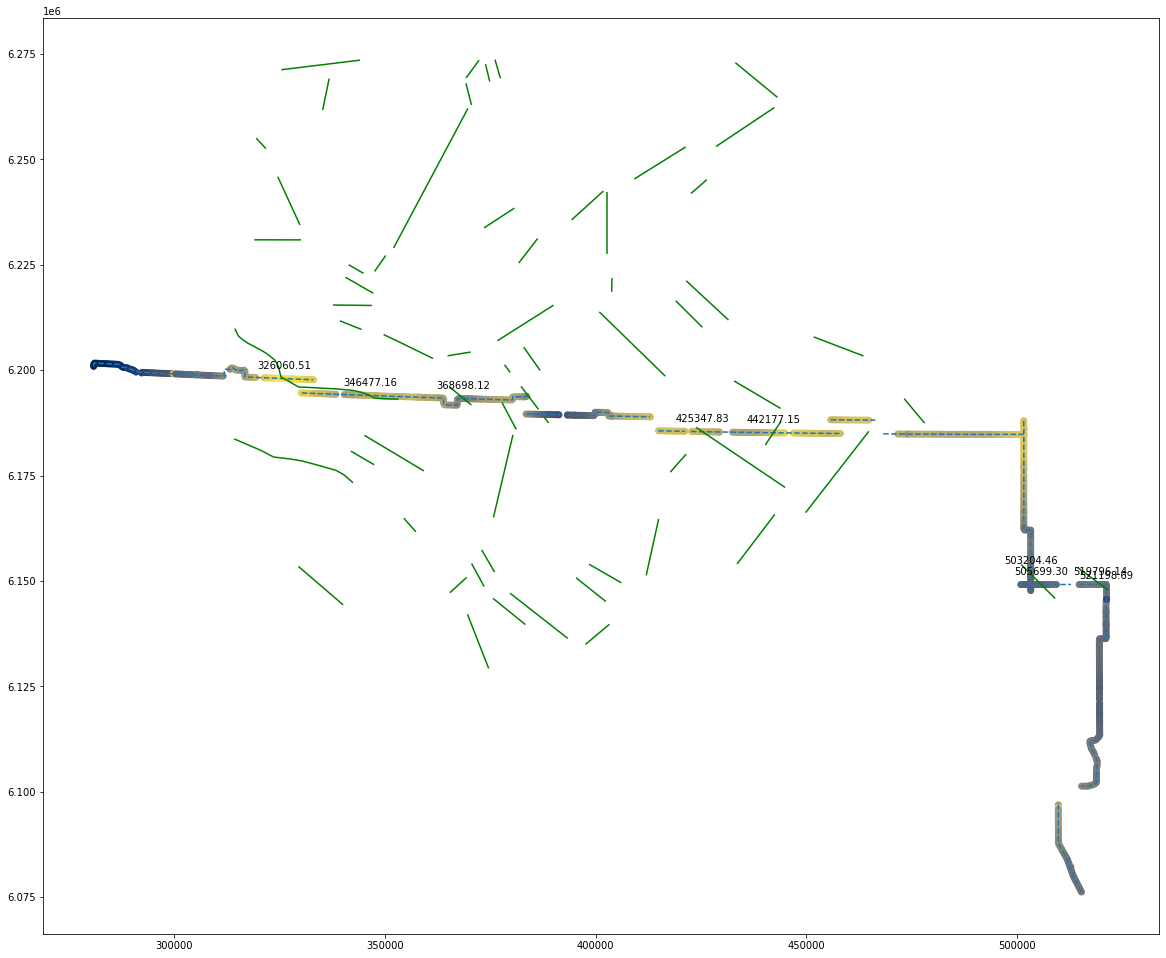

In [49]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
lithoprobe_26711.plot(ax = ax, linestyle='dashed')
faults_debolt_26711.plot(ax=ax, color='g')
# points_gdf.plot(ax=ax)
points_subset.plot(ax=ax, column='BOUGUER', cmap='cividis')

for x,y in zip(points_gdf['geometry'].x,points_gdf['geometry'].y):

    label = "{:.2f}".format(x)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


we can also plot it as interactive map, using folium. If necessary, convert the shapefiles to geojson format which is more convenient (code below)

In [50]:
points_gdf["easting_26711"] = points_gdf.geometry.x
points_gdf["northing_26711"] = points_gdf.geometry.y

let's convert the crs to WGS84 to get coordinates in lat/lon

In [65]:
points_wgs84 = points_gdf.to_crs(crs=4326)
points_subset_gravi_wgs84 = points_subset.to_crs(4326)
lithoprobe_wgs84 = lithoprobe.to_crs(crs=4326)
faults_debolt_wgs84 = faults_debolt.to_crs(crs=4326)

We can check how the map looks in geographic coordinates

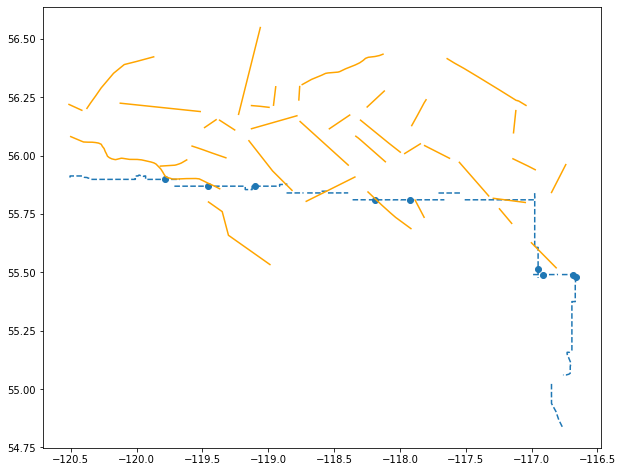

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
lithoprobe_wgs84.plot(ax = ax, linestyle='dashed')
faults_debolt_wgs84.plot(ax=ax, color='orange')
points_wgs84.plot(ax=ax);


Now let's create an interactive map with marked intersections

In [75]:
m = folium.Map(location=[55.91, -119], zoom_start=8, control_scale=True)

# for row in points_wgs84.iterrows():
#     location = (row[1][0].y, row[1][0].x)
#     popup = ('\nlatitude:' + 
#              str((row[1][0].x)) + 
#              '\nlongitude:' + str(row[1][0].y))
#     marker = folium.Marker(location = location, popup = popup, color='green')
#     marker.add_to(m) 
  

folium.GeoJson(faults_debolt_wgs84.to_json(),
               style_function=lambda x: {
                   'color' : 'green',
                   'weight' : 2,
                   'opacity': 0.7,
                   'fillColor' : 'blue',
               }).add_to(m)

folium.GeoJson(points_subset.to_json()).add_to(m)



# folium.GeoJson(points_subset_gravi_wgs84.to_json(),
#                style_function=lambda x: {
#                    'color' : 'green',
#                    'weight' : 2,
#                    'opacity': 0.7,
#                    'fillColor' : 'blue',
#                }).add_to(m)
               
folium.GeoJson(lithoprobe_wgs84,
    style_function=lambda x: {
        'color' : 'red',
        'weight' : 2,
        'opacity': 0.7,
        'fillColor' : 'blue',
        }).add_to(m)
m

more on icons change: https://stackoverflow.com/questions/60131314/folium-draw-star-marker